## Лабораторная работа № 1. Иерархическая кластеризация

In [31]:
import pandas as pd
import numpy as np

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from typing import Literal
from warnings import filterwarnings

filterwarnings('ignore')

Необходимые функции и классы:

In [32]:
def hist(df: pd.DataFrame, title_text: str): 
    BAR_COLORS = ['#D9A23E', '#C47451', '#D9A23E', '#6B8E7A', '#C47451', '#99A3B8'] * 2 
    BAR_COLORS = BAR_COLORS[:len(df.columns)] 

    PLOT_BG_COLOR = '#2D2A26'    
    AXIS_COLOR = '#D9CAB3'       
    GRID_COLOR = '#736E66'   
    TITLE_FONT_COLOR = 'white'

    AXIS_LABELS = {'yaxis_title': 'Частота'}

    ROWS = 4
    COLS = 3
    N_PLOTS = len(df.columns) 

    fig = make_subplots(
        rows=ROWS, 
        cols=COLS, 
        horizontal_spacing=0.05, 
        vertical_spacing=0.08,
        subplot_titles=[f'Распределение {col}' for col in df.columns]
    )

    for i, col in enumerate(df.columns):

        row = (i // COLS) + 1
        col_idx = (i % COLS) + 1
        
        current_color = BAR_COLORS[i]

        hist_trace = go.Histogram(
            x=df[col],
            name=col,
            marker=dict(
                color=current_color,
                line=dict(width=0.5, color=AXIS_COLOR) 
            ),
            xbins=dict(size=1.0) 
        )

        fig.add_trace(hist_trace, row=row, col=col_idx)

    fig.update_layout(
        title={
            'text': title_text,
            'y': 0.98,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': {'size': 18, 'color': TITLE_FONT_COLOR} 
        },
        showlegend=False,
        autosize=True,
        height=800,
        plot_bgcolor=PLOT_BG_COLOR, 
        paper_bgcolor=PLOT_BG_COLOR, 
        font_color=AXIS_COLOR, 
        font=dict(color=AXIS_COLOR) 
    )

    for i in range(1, N_PLOTS + 1):
        r = (i - 1) // COLS + 1
        c = (i - 1) % COLS + 1
        
        fig.update_xaxes(
            color=AXIS_COLOR,
            gridcolor=GRID_COLOR,
            row=r, col=c
        )
        
        fig.update_yaxes(
            title_text=AXIS_LABELS['yaxis_title'] if c == 1 else None,
            color=AXIS_COLOR,
            gridcolor=GRID_COLOR,
            row=r, col=c
        )

    fig.show()



def boxplots(df):

    PLOT_BG_COLOR = '#2D2A26'
    AXIS_COLOR = '#D9CAB3'
    TITLE_COLOR = 'white'

    df_melted = df.melt(var_name='Переменная', value_name='Значение')

    fig = px.box(
        df_melted,
        x='Переменная',
        y='Значение',
        title='Ящик с усами',
        color_discrete_sequence=['#D9A23E'] 
    )

    fig.update_layout(
        title={
            'text': 'Ящик с усами',
            'x': 0.5,
            'font': {'size': 18, 'color': TITLE_COLOR}
        },
        height=500,
        width=600,
        plot_bgcolor=PLOT_BG_COLOR,
        paper_bgcolor=PLOT_BG_COLOR,
        font=dict(color=AXIS_COLOR),
        xaxis=dict(
            tickfont=dict(color=AXIS_COLOR),
            linecolor=AXIS_COLOR,
            gridcolor='#736E66'
        ),
        yaxis=dict(
            tickfont=dict(color=AXIS_COLOR),
            linecolor=AXIS_COLOR,
            gridcolor='#736E66'
        )
    )

    fig.show()



def scale(df, scaler: str = 'Standard'):
    if scaler == 'Standard':
        model = StandardScaler().fit(df)
    else:
        model = MinMaxScaler().fit(df)
        
    scaled_df = model.transform(df)

    return pd.DataFrame(scaled_df, columns=df.columns, index=df.index)



class hierarchical_clustering:

    def __init__(self, df: pd.DataFrame, 
                 cluster_distance=Literal['ward', 'single', 'complete', 'average', 
                                          'weighted', 'centroid', 'median'], 
                 distance_measure=Literal['euclidean', 'cityblock', 'hamming', 'cosine'],
                 origin_df: pd.DataFrame = None):
        
        self.df = df
        self.cluster_distance = cluster_distance
        self.distance_measure = distance_measure
        self.origin_df = origin_df
        self._link_matrix = None
        self._df_result = None


    def link(self):
        if self._link_matrix is None:
            self._link_matrix = linkage(self.df, self.cluster_distance, self.distance_measure)
        
        return self._link_matrix


    def plot_dendrogram(self, threshold: int =-1):
        matrix = self.link()

        plt.rcParams['axes.facecolor'] = '#2D2A26'

        fig, ax = plt.subplots(figsize=(11, 5.5), 
                               facecolor='#2D2A26', 
                               edgecolor='#2D2A26')
        
        dn = dendrogram(matrix, ax=ax, labels=self.df.index, 
                        color_threshold=threshold, 
                        above_threshold_color='#D9CAB3', 
                        orientation='top')
        
        ax.tick_params(axis='x', colors='#D9CAB3')
        ax.tick_params(axis='y', colors='#D9CAB3')
        ax.set_title(f'Дендрограмма ({self.cluster_distance} / {self.distance_measure})', color='white')
        ax.set_xlabel('Индекс наблюдения', color='#D9CAB3')
        ax.set_ylabel('Расстояние между кластерами', color='#D9CAB3')
        
        plt.show()


    def plot_distance_change(self):
        matrix = self.link()

        dist = matrix[:, 2] 
        dist_rev = dist[::-1] 
        idxs = range(1, len(dist) + 1)

        plt.rcParams['axes.facecolor'] = '#2D2A26'
        fig, ax = plt.subplots(figsize=(9, 4), 
                               facecolor='#2D2A26', 
                               edgecolor='#2D2A26')
        
        ax.plot(idxs, dist_rev, marker='o', color='#D9A23E')
        ax.set_title('Расстояние между объединяемыми кластерами', color='white')
        ax.set_xlabel('Шаг объединения', color='#D9CAB3')
        ax.set_ylabel('Расстояние', color='#D9CAB3')
        
        ax.tick_params(axis='x', colors='#D9CAB3')
        ax.tick_params(axis='y', colors='#D9CAB3')
        ax.grid(color='#736E66', linestyle='--', linewidth=0.5)

        plt.show()


    def result_df(self, threshold: int, crit=Literal['distance', 'maxclust']):
        matrix = self.link()

        if self.origin_df is None:
            self._df_result = self.df.copy()

        else:
            self._df_result = self.origin_df.copy()

        self._df_result['cluster'] = fcluster(matrix, t=threshold, criterion=crit)

        return self._df_result

    def mean_by_cluster(self, threshold: int, crit=Literal['distance', 'maxclust']):
        df_result = self.result_df(threshold, crit)

        return df_result.groupby('cluster').mean()
    
    def cluster_size(self, threshold: int, crit=Literal['distance', 'maxclust']):
        df_result = self.result_df(threshold, crit)

        return df_result.groupby('cluster').size()


### Данные: Леденцы

Набор данных содержит оценки степени согласия респондентов с высказываниями, 
отражающими цель потребления леденцов. Всего каждый респондент выставлял оценки по 
11 высказываниям:

V1: Я потребляю леденцы, чтобы освежить дыхание

V2: Я потребляю леденцы, чтобы чувствовать себя увереннее

V3: Я потребляю леденцы, чтобы освежить полость рта

V4: Я потребляю леденцы, чтобы избавиться от неприятного вкуса во рту

V5: Я потребляю леденцы как заменитель других кондитерских изделий

V6: Я потребляю леденцы, когда мне хочется чего-нибудь сладкого

V7: Леденцы помогают мне сконцентрироваться

V8: Я потребляю леденцы, чтобы отвлечься на несколько минут и подумать

V9: Я потребляю леденцы для того, чтобы облегчить боль в горле

V10: Я потребляю леденцы для того, чтобы избавиться от заложенности носа

V11: Я потребляю леденцы для улучшения самочувствия

##### Разведочный анализ данных

In [33]:
df = pd.read_csv('data/Леденцы.dat', sep=';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338 entries, 0 to 337
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   V1      338 non-null    int64
 1   V2      338 non-null    int64
 2   V3      338 non-null    int64
 3   V4      338 non-null    int64
 4   V5      338 non-null    int64
 5   V6      338 non-null    int64
 6   V7      338 non-null    int64
 7   V8      338 non-null    int64
 8   V9      338 non-null    int64
 9   V10     338 non-null    int64
 10  V11     338 non-null    int64
dtypes: int64(11)
memory usage: 29.2 KB


In [34]:
# Проверка наличия пропусков
df.isna().sum()

V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
dtype: int64

In [35]:
# Описательная статистика
df.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11
count,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000
mean,3.544379,3.526627,3.517751,3.411243,3.207101,3.204142,3.254438,3.289941,3.603550,3.550296,3.565089
std,0.955748,0.956410,0.990150,0.992311,0.867314,0.869725,0.844107,0.821784,0.969682,0.927082,0.942042
min,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
25%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
50%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
75%,5.000000,5.000000,5.000000,4.000000,3.000000,3.000000,3.000000,3.000000,5.000000,5.000000,5.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [36]:
hist(df, title_text='Распределение оценок согласия с целями потребления леденцов')

In [37]:
# Корреляция
df.corr().style.background_gradient(cmap='Pastel2_r')

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11
V1,1.000000,0.899539,0.899093,0.861459,-0.039758,-0.037705,-0.131739,-0.224225,-0.432416,-0.422820,-0.425076
V2,0.899539,1.000000,0.974008,0.918605,-0.056749,-0.051146,-0.170143,-0.243930,-0.410932,-0.408131,-0.410322
V3,0.899093,0.974008,1.000000,0.933310,-0.028481,-0.023172,-0.161636,-0.232446,-0.431511,-0.417980,-0.422759
V4,0.861459,0.918605,0.933310,1.000000,0.049004,0.053720,-0.082780,-0.146652,-0.474584,-0.462838,-0.465190
V5,-0.039758,-0.056749,-0.028481,0.049004,1.000000,0.990175,0.008874,-0.105314,-0.537177,-0.518580,-0.517738
V6,-0.037705,-0.051146,-0.023172,0.053720,0.990175,1.000000,0.038171,-0.087211,-0.554675,-0.533518,-0.532365
V7,-0.131739,-0.170143,-0.161636,-0.082780,0.008874,0.038171,1.000000,0.937104,-0.383938,-0.372838,-0.371665
V8,-0.224225,-0.243930,-0.232446,-0.146652,-0.105314,-0.087211,0.937104,1.000000,-0.257491,-0.260681,-0.262098
V9,-0.432416,-0.410932,-0.431511,-0.474584,-0.537177,-0.554675,-0.383938,-0.257491,1.000000,0.972884,0.963874
V10,-0.422820,-0.408131,-0.417980,-0.462838,-0.518580,-0.533518,-0.372838,-0.260681,0.972884,1.000000,0.991760


По матрице можно предварительно понять какие утверждения говорят примерно об одном и том же

##### Кластеризация

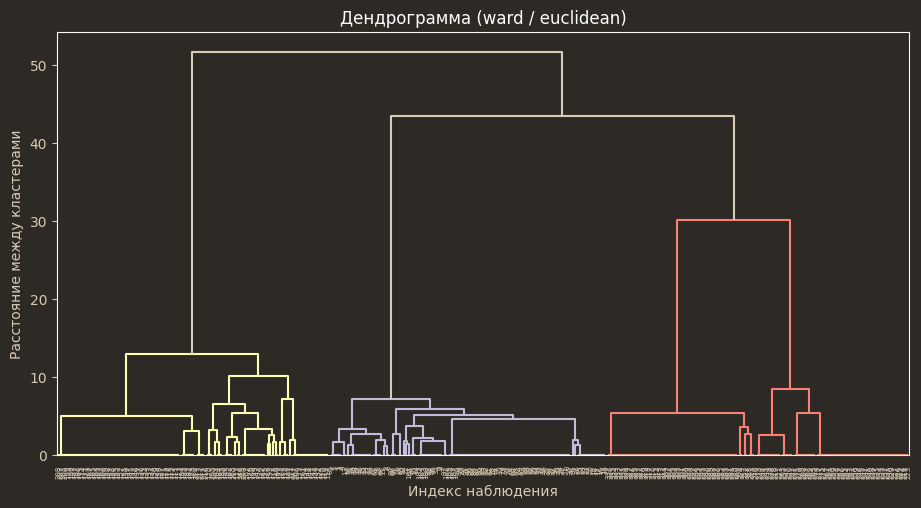

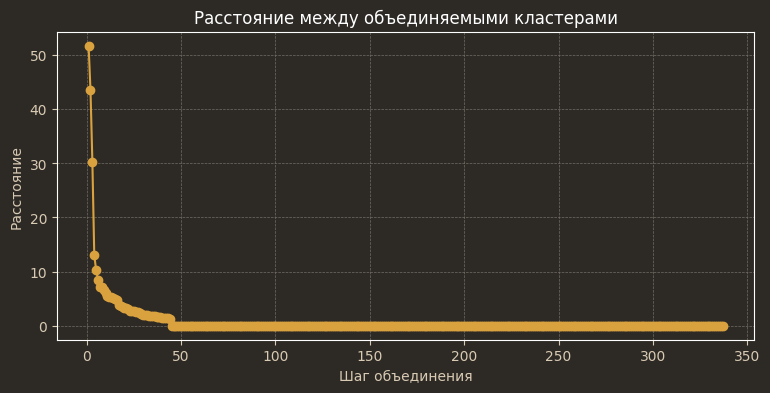

cluster
1    108
2    110
3    120
dtype: int64


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11
cluster,,,,,,,,,,,
1,2.824074,2.833333,2.768519,2.620370,2.611111,2.583333,2.750000,2.916667,4.953704,4.814815,4.861111
2,4.845455,4.800000,4.836364,4.681818,3.036364,3.036364,3.000000,2.990909,3.072727,3.045455,3.045455
3,3.000000,2.983333,2.983333,2.958333,3.900000,3.916667,3.941667,3.900000,2.875000,2.875000,2.875000


In [38]:
threshold = 35
criterion = 'distance' 

clusterization = hierarchical_clustering(df=df, 
                                         cluster_distance='ward',
                                         distance_measure='euclidean')

clusterization.plot_dendrogram(threshold=threshold)
clusterization.plot_distance_change()

print(clusterization.cluster_size(threshold=threshold, crit=criterion))
clusterization.mean_by_cluster(threshold=threshold, crit=criterion)

Выводы (3 кластера, ward + euclidean):

- видно, что в кластере 1 есть смещение к полному согласию в таких переменных, как V9, V10, V11. Это может указывать на группу людей, которые принимают леденцы для улучшения самочувствия и при болезни

- в кластере 2 превалируют утверждения с V1 по V4. Он группирует людей, которые уверены, что леденцы нужны для освежения дыхания

- кластер 3 содержит две подгруппы: 1-ая ценит леденцы как сладость, для 2-ой леденцы - это способ воздействия на умственную активность (либо сконцетрироваться на чем-то, либо отвлечься от чего-либо)


Можно задать 4 кластера и посмотреть разделиться ли 3-й кластер:

In [39]:
threshold = 4
criterion = 'maxclust' 

clusterization = hierarchical_clustering(df=df, 
                                         cluster_distance='ward',
                                         distance_measure='euclidean')

print(clusterization.cluster_size(threshold=threshold, crit=criterion))
clusterization.mean_by_cluster(threshold=threshold, crit=criterion)

cluster
1    108
2    110
3     59
4     61
dtype: int64


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11
cluster,,,,,,,,,,,
1,2.824074,2.833333,2.768519,2.620370,2.611111,2.583333,2.750000,2.916667,4.953704,4.814815,4.861111
2,4.845455,4.800000,4.836364,4.681818,3.036364,3.036364,3.000000,2.990909,3.072727,3.045455,3.045455
3,3.000000,2.966102,2.966102,2.915254,2.915254,2.949153,4.915254,4.915254,3.000000,3.000000,3.000000
4,3.000000,3.000000,3.000000,3.000000,4.852459,4.852459,3.000000,2.918033,2.754098,2.754098,2.754098


Выводы (4 кластера, ward + euclidean):

- видно, что при выборе 4-х кластеров, 3-й кластер из предыдущего примера разделился на два более логических кластера - что позволяет лучше интерпретировать позицию респондентов

### Данные: Экономика городов

Данные описывают экономические условия в 48 городах мира в 1991 году. 
Данные были собраны отделом экономических исследований банка Union (Швейцария). 
Описаны экономические условия в 48 городах мира в 1991 году. 


Число наблюдений: 48 

Названия переменных: 
- City (Город): Название города

- Работа (Work): Взвешенное среднее числа рабочих часов, сосчитанное по 12 
профессиям 

- Цена (Price): Индекс цен 112 товаров и услуг, включая арендную плату за 
жилье (значение для Цюриха взято за 100%) 

- Заработная плата (Salary): Индекс заработной платы за час работы, 
сосчитанный по 12 профессиям после налогов и вычетов  (значение для Цюриха 
взято за 100%)

##### Разведочный анализ данных

In [40]:
df = pd.read_csv('data/Econom_Cities_data.csv', sep=';', decimal=',').set_index('City', drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48 entries, Amsterdam to Zurich
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Work    48 non-null     int64  
 1   Price   48 non-null     float64
 2   Salary  48 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 1.5+ KB


In [41]:
# Проверка наличия пропусков
df.isna().sum()

Work      0
Price     0
Salary    0
dtype: int64

In [42]:
# Описательная статистика
df.describe()

,Work,Price,Salary
count,48.000000,48.000000,48.000000
mean,1384.958333,68.860417,-378.727083
std,2404.897007,21.784659,2027.338052
min,-9999.000000,30.300000,-9999.000000
25%,1740.750000,49.650000,12.250000
50%,1834.500000,70.500000,40.300000
75%,1972.750000,81.700000,58.700000
max,2375.000000,115.500000,100.000000


Видно подозрительные значения в строке min. Такого быть не может, поэтому нужно удалить эти выбросы:

In [43]:
indexes_for_drop = df[(df['Work'] < 0) | (df['Salary'] < 0)].index

df.drop(index=indexes_for_drop, inplace=True)

df.describe()

,Work,Price,Salary
count,46.000000,46.000000,46.000000
mean,1879.913043,70.100000,39.545652
std,174.342552,21.389177,24.757703
min,1583.000000,30.300000,2.700000
25%,1745.250000,51.775000,14.375000
50%,1849.000000,70.950000,43.650000
75%,1976.250000,81.900000,59.700000
max,2375.000000,115.500000,100.000000


In [44]:
# Проверка на выбросы
boxplots(df[['Work']])
boxplots(df[['Salary', 'Price']])

В целом, сильных выбросов не осталось, пока оставим наблюдение со значением 2375 признака Work. Перед кластеризацией также нормализуем данные, поскольку значения в колонке Work сильно отличаются от Price и Salary:

In [45]:
df_scaled = scale(df, scaler='Standard')
df_scaled.head()

,Work,Price,Salary
City,,,
Amsterdam,-0.962166,-0.212712,0.386095
Athens,-0.509827,-0.770489,-0.373488
Bogota,1.577891,-1.522069,-1.145323
Bombay,0.997969,-1.881316,-1.398517
Brussels,-0.996961,0.174896,0.447351


##### Кластеризация

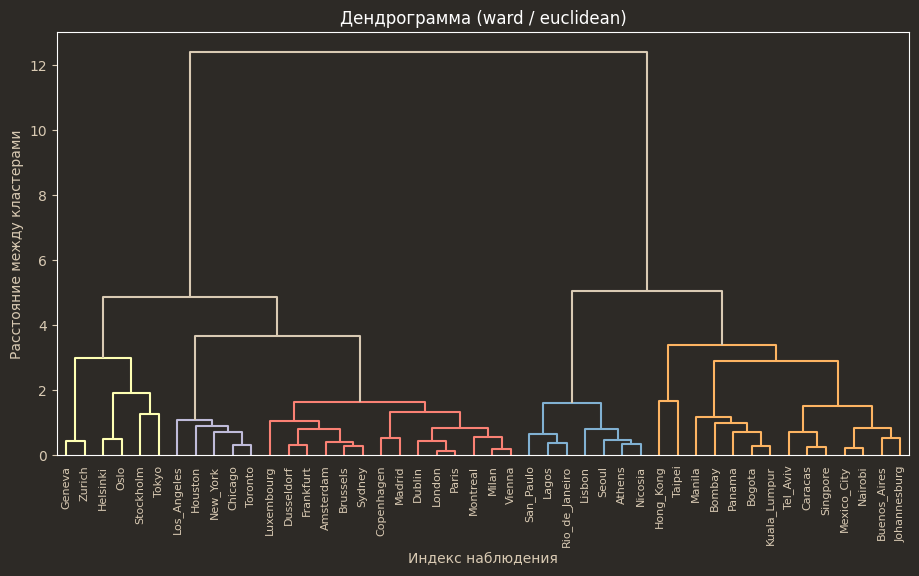

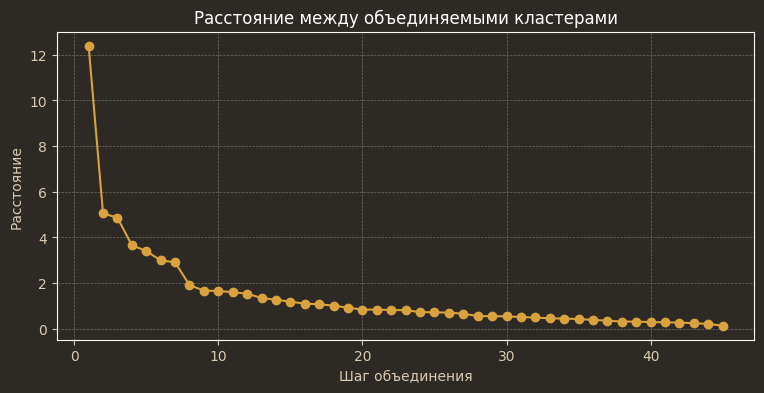

cluster
1     6
2     5
3    14
4     7
5    14
dtype: int64 

                Work       Price     Salary
cluster                                    
1        1780.500000  108.550000  71.300000
2        1960.000000   75.820000  59.480000
3        1732.000000   78.135714  53.614286
4        1798.857143   50.942857  19.214286
5        2082.357143   53.121429  14.914286


City
Geneva            1
Helsinki          1
Oslo              1
Stockholm         1
Tokyo             1
Zurich            1
Los_Angeles       2
Chicago           2
Toronto           2
New_York          2
Houston           2
Milan             3
Dublin            3
Dusseldorf        3
Montreal          3
Copenhagen        3
London            3
Luxembourg        3
Paris             3
Vienna            3
Madrid            3
Amsterdam         3
Brussels          3
Frankfurt         3
Sydney            3
Rio_de_Janeiro    4
Nicosia           4
Lagos             4
Lisbon            4
Athens            4
Seoul             4
San_Paulo         4
Nairobi           5
Manila            5
Mexico_City       5
Kuala_Lumpur      5
Johannesburg      5
Buenos_Aires      5
Bogota            5
Hong_Kong         5
Caracas           5
Bombay            5
Singpore          5
Panama            5
Taipei            5
Tel_Aviv          5
Name: cluster, dtype: int32

In [46]:
threshold = 3.6
criterion = 'distance' 

clusterization = hierarchical_clustering(df=df_scaled, 
                                         cluster_distance='ward',
                                         distance_measure='euclidean',
                                         origin_df=df)

clusterization.plot_dendrogram(threshold=threshold)
clusterization.plot_distance_change()

print(clusterization.cluster_size(threshold=threshold, crit=criterion), '\n')
print(clusterization.mean_by_cluster(threshold=threshold, crit=criterion))
clusterization._df_result['cluster'].sort_values()

Выводы (5 кластеров, scaled data, ward + euclidean):

По графикам дендрограммы и локтя видно, что данные хорошо разделяются на 4-5 кластеров.

- в 1-й кластер попали города с низким средним числа рабочих часов (Work), высоким индексом цен (Price) и высоким индексом зарплаты (Salary). Это преимущественно города Европы с высоким и стабильным уровнем жизни и низкой рабочей нагрузкой. Это кластер городов с наиболее благоприятным Work-Life Balance. Жители работали меньше всего, но сталкивались с очень высокими ценами, что, возможно, компенсировалось высокой заработной платой.

- во 2-ой кластер попали основные города Северной Америки. Они характеризуются высокой заработной платой, но существенно более низкой стоимостью жизни (75.82 против 108.55). Рабочая нагрузка выше, чем в скандинавских городах.

- 3-й кластер самый большой и представляет умеренно дорогие европейские города и некоторые мировые центры (Лондон, Париж). Условия экономики умеренные: низкая рабочая нагрузка, при этом цены и зарплаты высокие, но ниже, чем в кластерах 1 и 2 (за исключением цен кластера 2).

- 4-ый кластер содержит города с низкой рабочей нагрузкой, но оплата (19.21%) и цены (50.94%) также крайне низкие.

- 5-ый кластер характеризуется самой высокой рабочей нагрузкой и самым низким уровнем жизни. Сюда входят азиатские города (Сингапур, Тайбэй) и крупные города Латинской Америки (Каракас, Богота). Тяжелый труд за небольшие деньги.

Можно также взять 6 кластеров:

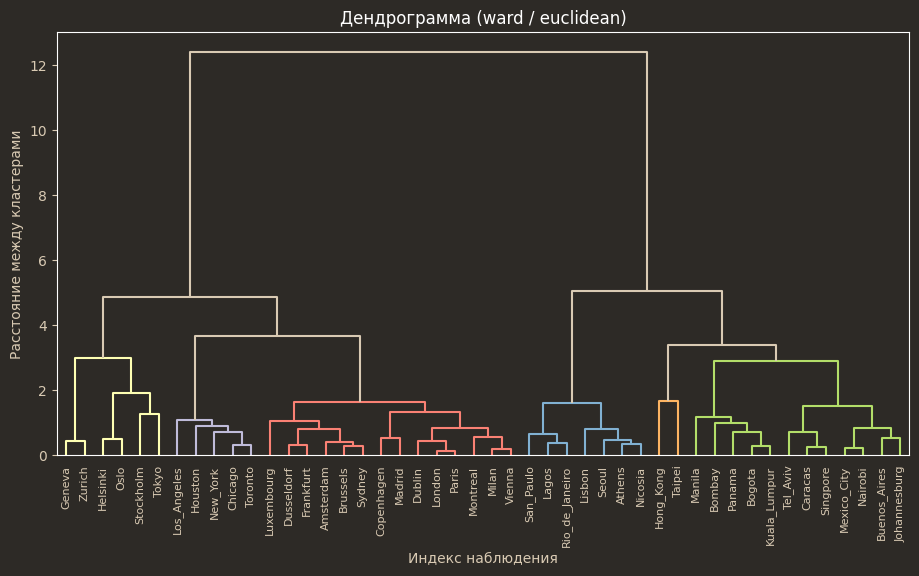

cluster
1     6
2     5
3    14
4     7
5     2
6    12
dtype: int64 

                Work       Price     Salary
cluster                                    
1        1780.500000  108.550000  71.300000
2        1960.000000   75.820000  59.480000
3        1732.000000   78.135714  53.614286
4        1798.857143   50.942857  19.214286
5        2260.000000   74.050000  31.150000
6        2052.750000   49.633333  12.208333


City
Geneva            1
Helsinki          1
Oslo              1
Stockholm         1
Tokyo             1
Zurich            1
Los_Angeles       2
Chicago           2
Toronto           2
New_York          2
Houston           2
Milan             3
Dublin            3
Dusseldorf        3
Montreal          3
Copenhagen        3
London            3
Luxembourg        3
Paris             3
Vienna            3
Madrid            3
Amsterdam         3
Brussels          3
Frankfurt         3
Sydney            3
Rio_de_Janeiro    4
Nicosia           4
Lagos             4
Lisbon            4
Athens            4
Seoul             4
San_Paulo         4
Taipei            5
Hong_Kong         5
Nairobi           6
Kuala_Lumpur      6
Johannesburg      6
Buenos_Aires      6
Bogota            6
Bombay            6
Caracas           6
Manila            6
Mexico_City       6
Panama            6
Singpore          6
Tel_Aviv          6
Name: cluster, dtype: int32

In [47]:
threshold = 3.3
criterion = 'distance' 

clusterization = hierarchical_clustering(df=df_scaled, 
                                         cluster_distance='ward',
                                         distance_measure='euclidean',
                                         origin_df=df)

clusterization.plot_dendrogram(threshold=threshold)

print(clusterization.cluster_size(threshold=threshold, crit=criterion), '\n')
print(clusterization.mean_by_cluster(threshold=threshold, crit=criterion))
clusterization._df_result['cluster'].sort_values()

Так, 5-ый кластер из предыдущего примера разделяется на 5 и 6, где выделяются такие города как Гонконг и Тайбэй. В них экстремально высокая рабочая нагрузка, при средних индексах цен и зарплаты. Эти города контрастируют с 6-ым кластером, где высокая нагрузка, но самые низкие цены и зарплаты.

По графику Локтя также заметен изгиб при 8 кластерах:

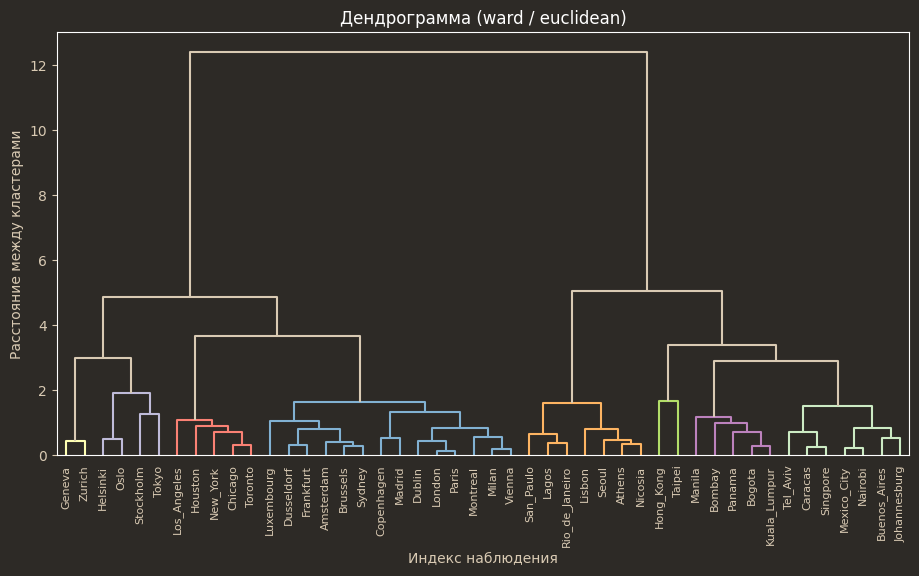

cluster
1     2
2     4
3     5
4    14
5     7
6     2
7     5
8     7
dtype: int64 

                Work       Price     Salary
cluster                                    
1        1874.000000   97.950000  95.150000
2        1733.750000  113.850000  59.375000
3        1960.000000   75.820000  59.480000
4        1732.000000   78.135714  53.614286
5        1798.857143   50.942857  19.214286
6        2260.000000   74.050000  31.150000
7        2143.400000   40.180000   8.900000
8        1988.000000   56.385714  14.571429


City
Geneva            1
Zurich            1
Oslo              2
Helsinki          2
Stockholm         2
Tokyo             2
Los_Angeles       3
Chicago           3
Toronto           3
New_York          3
Houston           3
Milan             4
Dublin            4
Dusseldorf        4
Montreal          4
Copenhagen        4
London            4
Luxembourg        4
Paris             4
Vienna            4
Madrid            4
Amsterdam         4
Brussels          4
Frankfurt         4
Sydney            4
Rio_de_Janeiro    5
Nicosia           5
Lagos             5
Lisbon            5
Athens            5
Seoul             5
San_Paulo         5
Taipei            6
Hong_Kong         6
Bogota            7
Panama            7
Kuala_Lumpur      7
Bombay            7
Manila            7
Caracas           8
Nairobi           8
Mexico_City       8
Johannesburg      8
Buenos_Aires      8
Singpore          8
Tel_Aviv          8
Name: cluster, dtype: int32

In [48]:
threshold = 2.5
criterion = 'distance' 

clusterization = hierarchical_clustering(df=df_scaled, 
                                         cluster_distance='ward',
                                         distance_measure='euclidean',
                                         origin_df=df)

clusterization.plot_dendrogram(threshold=threshold)

print(clusterization.cluster_size(threshold=threshold, crit=criterion), '\n')
print(clusterization.mean_by_cluster(threshold=threshold, crit=criterion))
clusterization._df_result['cluster'].sort_values()

При K=8 алгоритм изолировал Цюрих и Женеву в отдельный кластер, который отличается самой высокой заработной платой среди всех групп.

Скандинавские столицы и Токио сформировали свой кластер, характеризующийся экстремально высокой ценой (113.85%). Это показывает, что, несмотря на высокую зарплату, их основной отличительный признак — это стоимость жизни, превышающая Цюрих.

### Данные: Цифры

Каждая строка набора данных описывает цифру. Цифры отсканированы с ошибками. В обучающей выборке присутствует группирующая переменная - правильная цифра.

Первый этап. Сначала кластеризуем наблюдения, чтобы похожие цифры собрались в группы. Определить число кластеров и разбить цифры на кластеры. Также предложить интерпретацию для каждого кластера. 

Группирующую переменную 'A' нельзя использовать при кластеризации, 
но рекомендуется использовать ее при интерпретации кластеров.

В данных 7 переменных с именами 'B' - 'H', измеренных в номинальной шкале 
0 = линия присутствует 
1 = линия отсутствует 

Линии соответствуют черточкам на экране калькулятора

B - top horizontal, 
C - upper left vertical, 
D - upper right vertical, 
E - middle horizontal, 
F - lower left vertical, 
G - lower right vertical, 
H - bottom horizontal.  

В наборе данных 8 переменных и 500 наблюдений. По неизвестной причине в таблице данных каждый столбец присутствует дважды

In [49]:
# Загружаем данные и избавляемся от дублирующихся столбцов
df = pd.read_csv('data/digit.dat', sep=';').iloc[:, :8]

df = df.apply(lambda x: x.str.strip() if x.dtype == object else x).set_index('A')

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, seven to seven
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   B       500 non-null    object
 1   C       500 non-null    object
 2   D       500 non-null    object
 3   E       500 non-null    object
 4   F       500 non-null    object
 5   G       500 non-null    object
 6   H       500 non-null    object
dtypes: object(7)
memory usage: 31.2+ KB


##### Разведочный анализ данных

In [50]:
# Проверка наличия пропусков
df.isna().sum()

B    0
C    0
D    0
E    0
F    0
G    0
H    0
dtype: int64

In [51]:
# Описательная статистика
df.describe()

,B,C,D,E,F,G,H
count,500,500,500,500,500,500,500
unique,2,2,2,2,2,2,2
top,ONE,ONE,ONE,ONE,ZERO,ONE,ONE
freq,375,299,363,363,290,416,334


Заменим текст в данных на числа:

In [52]:
mapping_dict = {'ZERO': 0,
                'ONE': 1,
                'zero': 0,
                'one': 1,
                'two': 2,
                'three': 3,
                'four': 4,
                'five': 5,
                'six': 6,
                'seven': 7,
                'eight': 8,
                'nine': 9}

df_numeric = df.replace(mapping_dict)
df_numeric

,B,C,D,E,F,G,H
A,,,,,,,
seven,1,0,1,0,0,1,0
one,0,0,1,0,0,1,0
four,0,1,1,1,0,1,0
two,1,1,1,1,1,0,0
eight,0,1,1,1,1,1,1
...,...,...,...,...,...,...,...
five,1,1,0,1,0,1,1
seven,1,0,1,1,1,1,0
four,0,0,1,1,1,0,0


In [53]:
df_numeric.describe()

,B,C,D,E,F,G,H
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.750000,0.598000,0.726000,0.726000,0.420000,0.832000,0.668000
std,0.433446,0.490793,0.446456,0.446456,0.494053,0.374241,0.471403
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.750000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [54]:
hist(df_numeric, title_text='Гистограммы Цифр')

In [55]:
# Корреляция
df_numeric.corr().style.background_gradient(cmap='Pastel2_r')

,B,C,D,E,F,G,H
B,1.000000,0.073007,-0.116503,0.121681,0.163768,-0.037062,0.397216
C,0.073007,1.000000,-0.229322,0.227969,0.119177,0.231655,0.192881
D,-0.116503,-0.229322,1.000000,-0.206491,-0.095034,-0.036174,-0.176005
E,0.121681,0.227969,-0.206491,1.000000,-0.013265,-0.096145,0.338184
F,0.163768,0.119177,-0.095034,-0.013265,1.000000,-0.246254,0.247126
G,-0.037062,0.231655,-0.036174,-0.096145,-0.246254,1.000000,-0.100963
H,0.397216,0.192881,-0.176005,0.338184,0.247126,-0.100963,1.000000


##### Кластеризация

Исходя из предположения, что цифры отображаются как 0-9 - можно задать 10 кластеров:

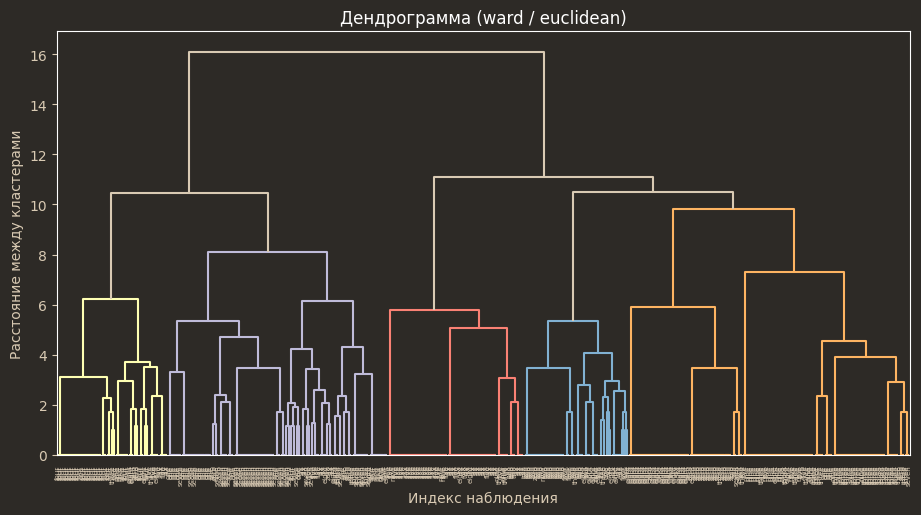

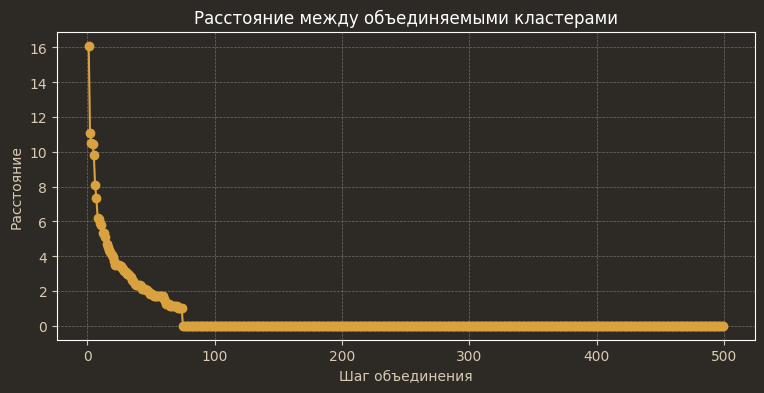

cluster
1     34
2     31
3     69
4     28
5     32
6     80
7     61
8     67
9     42
10    56
dtype: int64 

                B         C         D         E         F         G         H
cluster                                                                      
1        0.029412  0.852941  1.000000  1.000000  0.000000  0.852941  0.000000
2        0.000000  0.967742  0.548387  0.903226  0.548387  0.967742  0.806452
3        0.507246  0.188406  1.000000  0.000000  0.115942  0.913043  0.057971
4        0.785714  0.678571  0.000000  0.428571  0.428571  0.964286  0.214286
5        1.000000  0.531250  1.000000  0.812500  0.343750  1.000000  0.000000
6        1.000000  0.800000  0.000000  1.000000  0.475000  0.950000  1.000000
7        0.836066  0.344262  0.754098  0.983607  0.754098  0.000000  0.885246
8        1.000000  0.955224  1.000000  0.537313  1.000000  0.910448  1.000000
9        1.000000  1.000000  1.000000  1.000000  0.000000  1.000000  1.000000
10       0.803571  0.000000  

In [56]:
threshold = 10
criterion = 'maxclust' 

clusterization = hierarchical_clustering(df=df_numeric, 
                                         cluster_distance='ward',
                                         distance_measure='euclidean')

clusterization.plot_dendrogram(threshold=threshold)
clusterization.plot_distance_change()

print(clusterization.cluster_size(threshold=threshold, crit=criterion), '\n')
print(clusterization.mean_by_cluster(threshold=threshold, crit=criterion))

Выводы:

- кластер 1 - 4 (если 9 без H, иначе в редких случаях 9)

- кластер 2 - 4 (реже 6, если без B)

- кластер 3 - 7, реже 1, очень редко 3

- кластер 4 - 5 или 6 

- кластер 5 - 7 (если 9 без H, иначе в части случаях 9)

- кластер 6 - 5 (реже 6, если c B)

- кластер 7 - может быть невсегда только 2

- кластер 8 - 8, реже 0

- кластер 9 - 9 в 100% случаях

- кластер 10 - может быть невсегда только 3

Попробуем взять меру росстояния 'cityblock':

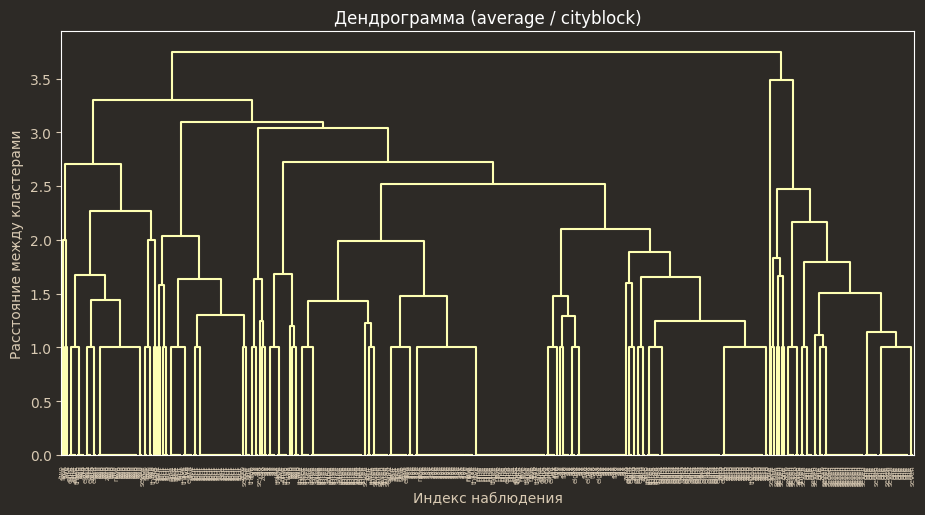

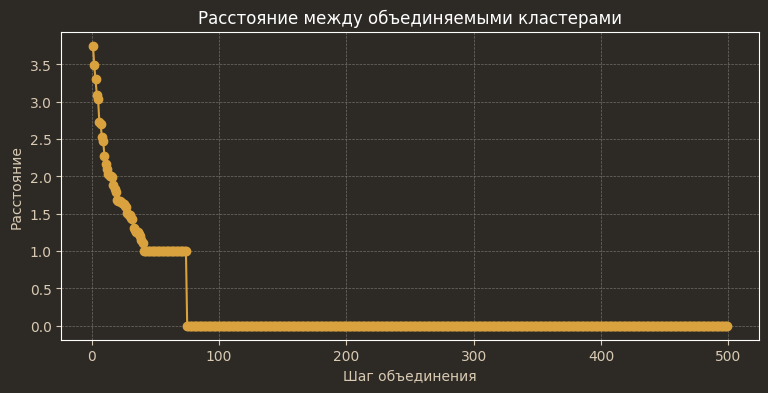

cluster
1       4
2      52
3      55
4      10
5      19
6     144
7     131
8       9
9      75
10      1
dtype: int64 

                B         C         D         E         F         G         H
cluster                                                                      
1        0.750000  0.750000  0.500000  1.000000  1.000000  0.000000  0.000000
2        0.865385  0.230769  1.000000  0.884615  0.769231  0.000000  0.903846
3        0.000000  0.981818  0.818182  0.909091  0.109091  0.945455  0.272727
4        1.000000  1.000000  0.000000  0.000000  0.700000  0.900000  0.500000
5        0.947368  0.000000  0.000000  1.000000  0.526316  0.631579  1.000000
6        0.937500  0.638889  0.729167  1.000000  0.013889  1.000000  0.791667
7        0.908397  0.916031  0.641221  0.740458  0.984733  0.923664  0.923664
8        0.444444  0.000000  0.000000  0.333333  0.111111  1.000000  0.111111
9        0.546667  0.106667  1.000000  0.000000  0.146667  0.920000  0.146667
10       0.000000  

In [57]:
threshold = 10
criterion = 'maxclust' 

clusterization_manh = hierarchical_clustering(df=df_numeric, 
                                         cluster_distance='average',
                                         distance_measure='cityblock')

clusterization_manh.plot_dendrogram(threshold=threshold)
clusterization_manh.plot_distance_change()

print(clusterization_manh.cluster_size(threshold=threshold, crit=criterion), '\n')
print(clusterization_manh.mean_by_cluster(threshold=threshold, crit=criterion))

Лучше не стало: например есть кластеры 1 и 4, которые не содержат никакой цифры. Оставим кластеры при использовании евклидовы меры. Теперь можно поменять кластеры на получившиеся цифры, а затем посмотреть на долю правильных ответов:

In [58]:
# Преобразуем кластеры в числовой эквивалент
new_df = clusterization._df_result.copy()

mapping_predictions = {1: 4, 
                       2: 4, 
                       3: 7, 
                       4: 6, 
                       5: 7, 
                       6: 5, 
                       7: 2,
                       8:8,
                       9:9,
                       10:3}

new_df['prediction'] = new_df['cluster'].replace(mapping_predictions)
new_df['true'] = new_df.reset_index().replace(mapping_dict).set_index(df_numeric.index)['A']

yes = new_df[new_df['prediction'] == new_df['true']]

print(f'Доля правильных ответов = {len(yes) / len(new_df)}')

Доля правильных ответов = 0.504


Итого было угадано около половины цифр. Попробуем взять больше кластеров:

In [59]:
threshold = 12
criterion = 'maxclust' 

clusterization = hierarchical_clustering(df=df_numeric, 
                                         cluster_distance='ward',
                                         distance_measure='euclidean')

print(clusterization.cluster_size(threshold=threshold, crit=criterion), '\n')
print(clusterization.mean_by_cluster(threshold=threshold, crit=criterion))

cluster
1     34
2     31
3     69
4     28
5     32
6     35
7     45
8     61
9     36
10    31
11    42
12    56
dtype: int64 

                B         C         D         E         F         G         H
cluster                                                                      
1        0.029412  0.852941  1.000000  1.000000  0.000000  0.852941  0.000000
2        0.000000  0.967742  0.548387  0.903226  0.548387  0.967742  0.806452
3        0.507246  0.188406  1.000000  0.000000  0.115942  0.913043  0.057971
4        0.785714  0.678571  0.000000  0.428571  0.428571  0.964286  0.214286
5        1.000000  0.531250  1.000000  0.812500  0.343750  1.000000  0.000000
6        1.000000  1.000000  0.000000  1.000000  0.000000  1.000000  1.000000
7        1.000000  0.644444  0.000000  1.000000  0.844444  0.911111  1.000000
8        0.836066  0.344262  0.754098  0.983607  0.754098  0.000000  0.885246
9        1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000
10       1.

Здесь:

- кластер 1 - 4 (если 9 без H, иначе в редких случаях 9)

- кластер 2 - 4 (реже 6, если без B)

- кластер 3 - 7, реже 1

- кластер 4 - 5 или 6 

- кластер 5 - 9

- кластер 6 - 5 100%

- кластер 7 - 6

- кластер 8 - 2

- кластер 9 - 8 в 100% случаях

- кластер 10 - 0

- кластер 11 - 9 100%

- кластер 12 - может быть только 3

In [60]:
# Преобразуем кластеры в числовой эквивалент
new_df = clusterization._df_result.copy()

mapping_predictions = {1: 4, 
                       2: 4, 
                       3: 7, 
                       4: 6, 
                       5: 9, 
                       6: 5, 
                       7: 6,
                       8: 2,
                       9: 8,
                       10: 0,
                       11: 9,
                       12: 3}

new_df['prediction'] = new_df['cluster'].replace(mapping_predictions)
new_df['true'] = new_df.reset_index().replace(mapping_dict).set_index(df_numeric.index)['A']

yes = new_df[new_df['prediction'] == new_df['true']]

print(f'Доля правильных ответов = {len(yes) / len(new_df)}')

Доля правильных ответов = 0.602


Удалось повысить точность до 60%